In [1]:
import tensorflow as tf
import pandas as pd
import re
import keras
from keras import Model
from tensorflow.keras.layers import Flatten, LSTM, Dense, Embedding, SpatialDropout1D, Dropout, AveragePooling1D, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras_preprocessing.text import Tokenizer
from keras.initializers import glorot_uniform
from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Open csv with political reviews
with open('/content/drive/MyDrive/political.csv', 'r', encoding='utf-8', errors='ignore') as file:
    text = file.readlines()
# create dataframe
x_political = pd.DataFrame()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Fill dataframe, label = 1 means positive review, label = 0 means negative
word = []
label = []
for n in text:
    n = n.split(",")
    label.append(1) if "1" in n[0] else label.append(0)
    word.append(" ".join(n[1:]))
x_political['review'] = word
x_political['sentiment'] = label

In [9]:
# view raw text and compare with frame
for i in range(1, 10):
  print(text[i])
  print(x_political.iloc[i])
  print()

0,"terrible!, another Liberal from Massachusetts Attacks Palin and Proves That He Does not Ã¢â‚¬â„¢t Know What HeÃ¢â is Talking About.",

review       "terrible!  another Liberal from Massachusetts...
sentiment                                                    0
Name: 1, dtype: object

0,is not OK the Republican party (Socialism Lite) is not standing up for the Constitution. They want to implement their plan.. NO PLAN! Jeez..,

review       is not OK the Republican party (Socialism Lite...
sentiment                                                    0
Name: 2, dtype: object

0,shut up!! we do not need another conservative voice,

review       shut up!! we do not need another conservative ...
sentiment                                                    0
Name: 3, dtype: object

0,This is bad!! communist Obama uses people to push his communist agenda in the background!!!,

review       This is bad!! communist Obama uses people to p...
sentiment                                           

In [10]:
# Convert reviews column to list for further processing
x_list = x_political['review'].values.tolist()
y_list = x_political['sentiment'].values.tolist()
print(x_list)
print(y_list)

["I do not agree with them and also think that most liberals don't spend a lot of time thinking about tolerating. Tolerance connotes condescension. \n", '"terrible!  another Liberal from Massachusetts Attacks Palin and Proves That He Does not Ã¢â‚¬â„¢t Know What HeÃ¢â is Talking About." \n', 'is not OK the Republican party (Socialism Lite) is not standing up for the Constitution. They want to implement their plan.. NO PLAN! Jeez.. \n', 'shut up!! we do not need another conservative voice \n', 'This is bad!! communist Obama uses people to push his communist agenda in the background!!! \n', "And guess what? It's wrong. You're such a mindless shill that you can't even tell right from wrong. Typical liberal hypocrite \n", '"Others think he\'s the anti-Christ. That\'s why liberals tend to get butts kicked in policy  we\'re NOT one-minded enough!" \n', "McCain STILL doesn't understand why he lost! \n", 'Better dead than Red! RT @Ladymoves Should a communist be adviseing our president? Becaus

In [11]:
# Clean data
def data_prep(in_text):
    # remove punctuations and numbers
    out_text = re.sub('[^a-zA-Z]', ' ', in_text)
    # convert upper case to lower case
    out_text = "".join(list(map(lambda x: x.lower(), out_text)))
    # Remove single characters
    out_text = re.sub(r"\s+[a-zA-Z]\s+", ' ', out_text)
    return out_text

In [12]:
# create new cleaned dataset
political_set = []
for reviews in list(x_list):
    political_set.append(data_prep(reviews))

In [13]:
# Print a sample of the cleaned reviews
print(political_set)
print()

['i do not agree with them and also think that most liberals don spend lot of time thinking about tolerating  tolerance connotes condescension   ', ' terrible   another liberal from massachusetts attacks palin and proves that he does not know what he    is talking about    ', 'is not ok the republican party  socialism lite  is not standing up for the constitution  they want to implement their plan   no plan  jeez    ', 'shut up   we do not need another conservative voice  ', 'this is bad   communist obama uses people to push his communist agenda in the background     ', 'and guess what  it wrong  you re such mindless shill that you can even tell right from wrong  typical liberal hypocrite  ', ' others think he the anti christ  that why liberals tend to get butts kicked in policy  we re not one minded enough    ', 'mccain still doesn understand why he lost   ', 'better dead than red  rt  ladymoves should communist be adviseing our president  because there is   ', 'liberals are stupid an

In [14]:
# Pass cleaned data to a pandas frame
x_political = pd.DataFrame()
x_political['review'] = political_set
x_political['sentiment'] = y_list
print(x_political)

                                                 review  sentiment
0     i do not agree with them and also think that m...          0
1      terrible   another liberal from massachusetts...          0
2     is not ok the republican party  socialism lite...          0
3     shut up   we do not need another conservative ...          0
4     this is bad   communist obama uses people to p...          0
...                                                 ...        ...
1342  a total disgrace  taxpayers are paying fortune...          0
1343  very very unfair   the system is rigged  gener...          0
1344  rigged don think the voters will forget the ri...          0
1345  crooked crooked hillary clinton is unfit to se...          0
1346  dishonest  crooked hillary has once again been...          0

[1347 rows x 2 columns]


In [15]:
# Split data into 70% train and 30% test
pol_train, pol_test, sent_train, sent_test = model_selection.train_test_split(x_political['review'], x_political['sentiment'], test_size=0.30)

# convert lists into arrays to tokenize data
pol_train = np.array(pol_train.values.tolist())
pol_test = np.array(pol_test.values.tolist())
sent_train = np.array(sent_train.values.tolist())
sent_test = np.array(sent_test.values.tolist())

In [16]:
# Tokenize data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pol_train)
word_index = tokenizer.word_index
total_size = len(word_index)+1
print("Length of word index", total_size)

Length of word index 4490


In [17]:
# Convert the text input to sequences for processing in the LSTM
pol_train = tokenizer.texts_to_sequences(pol_train)
pol_test = tokenizer.texts_to_sequences(pol_test)
print(len(pol_train))
print(len(pol_test))
# Add padding so that all arrays have the same size
max_length = 50
pol_train = pad_sequences(pol_train, padding='post', maxlen=max_length)
pol_test = pad_sequences(pol_test, padding='post', maxlen=max_length)

print(pol_train)
print(pol_train.shape)

942
405
[[  63   77  276 ...    0    0    0]
 [ 172  811    1 ...    0    0    0]
 [  80   30 1110 ...    0    0    0]
 ...
 [ 460   39  537 ...    0    0    0]
 [1690   22  240 ...    0    0    0]
 [  23  271   14 ...    0    0    0]]
(942, 50)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 64)            287360    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            13600     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 40)            9760      
_________________________________________________________________
flatten (Flatten)            (None, 2000)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2000)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                128064    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

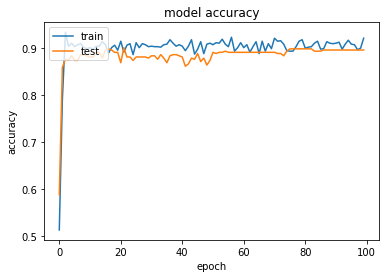

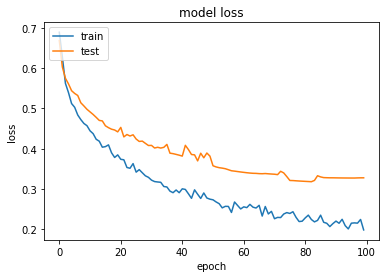

<Figure size 432x288 with 0 Axes>

In [18]:
# Finally create and structure the model
model = Sequential()
model.add(Embedding(total_size, 64, input_length=max_length, mask_zero=True))
#model.add(SpatialDropout1D(0.25))
model.add(Bidirectional(LSTM(20, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
model.add(Bidirectional(LSTM(20, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
#model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
#model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(64, activation='softmax'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model, specify optimizer, loss function and metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())
hystory = model.fit(pol_train, sent_train, batch_size=32, epochs=100, verbose=1, validation_data=(pol_test, sent_test))
model.save("/content/drive/MyDrive/2bi_pol.h5")

#List all data in history
print(hystory.history.keys())

#Plotting accuracy
plt.plot(hystory.history['acc'])
plt.plot(hystory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('accuracy_plot.png')

#Plotting loss
plt.plot(hystory.history['loss'])
plt.plot(hystory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('loss_plot.png')

In [19]:
test_set = ["just another terrorist trying to destroy our country worst candidate ever how incompetent"]
test_set = np.array(test_set) 

# Convert the text input to sequences for processing in the LSTM
test_set = tokenizer.texts_to_sequences(test_set)

# Add padding so that all arrays have the same size
max_length = 50
test_set = pad_sequences(test_set, padding='post', maxlen=max_length)
print(test_set)

[[  51  163 1115 1465    2 3705   13   78   97  524  300   86  204    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]


In [21]:
#Load the model
model = keras.models.load_model("/content/drive/MyDrive/2bi_pol.h5")
# Generate predictions on political data
print("Generating predictions LSTM vs Group 2")
predictions = model.predict(test_set)
print(predictions)

Generating predictions LSTM vs Group 2
[[0.08006275]]


In [22]:
test_set = ["i will vote for Trump"]
test_set = np.array(test_set) 

# Convert the text input to sequences for processing in the LSTM
test_set = tokenizer.texts_to_sequences(test_set)

# Add padding so that all arrays have the same size
max_length = 50
test_set = pad_sequences(test_set, padding='post', maxlen=max_length)
print(test_set)

[[ 80  25 199   8  45   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


In [23]:
#Load the model
model = keras.models.load_model("/content/drive/MyDrive/2bi_pol.h5")
# Generate predictions on political data
print("Generating predictions LSTM vs Group 2")
predictions = model.predict(test_set)
print(predictions)

Generating predictions LSTM vs Group 2
[[0.32511762]]
